[Further Reading on Optimization & QAOA Background](https://github.com/nicolasthill/Qiskit-Hackathon-at-World-of-QUANTUM/blob/main/QAOA%20101/QAOA_and_Optimization.ipynb)


## 1. Optimization
* Optimize y while controlling x
    * Find a function f which generates a solution; y = f(x)
* Cost function: the loss that we are trying to minimize
* Cost function in quantum mechanics
    * The system occupies the state of least energy
    * Likelihood of finding a local minimum is lower due to quantum annealing
* Quantum annealing
    * Start with a uniform superposition of all possible states
    * System evolves following the time-dependent Schrödinger equation
    * The amplitudes of all candidate states keep changing
        * Ending up in the ground state -> solution is found


## 2. QAOA
* QAOA: Quantum Approximate Optimization Algorithm
    * gives an approximately optimal solution using quantum methods
    * designed to solve combinatorial optimization problems
    * constraint: only linear and quadratic terms are allowed for the cost function
* Hamiltonian: something that governs the behaviour of any quantum system
    * Defines the energies that our system can be in
    * QAOA finds the ground state (state which corresponds to lowest energy level) of a given Hamiltonian
    * We can translate any cost function into a Hamiltonian
    * Minimizing the cost function is equivalent to finding the ground state of the Hamiltonian
* Adiabatic theorem: if we have a system in its ground state and we transform this system slowly enough, it will remain in its lowest energy state
* Constructing a time evolution operator for transformation
    * Not trivial because the problem and mixer Hamiltonian don’t compute
    * Use trotterizaton formula
    * At each step mixer and problem Hamiltonian exponents are supplied with a parameter beta and gamma respectively
        * These parameters play a key role because they simulate the adiabatic process
    * Naturally one would expect betas to decrease and gammas to increase
        * This reflects the fact that weight of the problem Hamiltonian should increase and the weight of mixer decrease
* Exponentiating the mixer Hamiltonian
    * Applying a rotational X gate to each qubit at an angle 2 beta
    * Applying a number of rotational Z gates and controlled rotational Z gates to all the qubits
    * Rotations also depend on the coefficients from QUBO matrix
* QAOA algorithm
    * At each optimization step, measure the state of the parameterized circuit
        * Measurement results in a distribution of probabilities
    * To evaluate cost, scale the energy for each bitstring that we measured with its probability and take the average
    * Classical optimizer now tries to minimize this energy by updating parameter of the circuit
    * Measure quantum state after updating parameters
    * Continue until optimizer lands in an optimal solution


In [18]:
from IPython.display import Image
Image(url= "images/Adiabatic-quantum-computation.png")
#source: https://www.researchgate.net/figure/Adiabatic-quantum-computation-The-energy-landscape-is-first-a-simple-one-with-one-global_fig2_315416652

Before we can understand how it is done, we are going to need some mathematical background.

As we mentioned, Hamiltonian governs the time evolution of quantum system. In particular in the following way:

$
\psi(t) = e^{-iHt/h}\psi(0)
$

Going back to our idea of transforming a quantum system, we can think of the following transformation:

$
H(t) = \frac{t}{T} H_{c} + (1 - \frac{t}{T})H_{m}
$

This is the point where we take advantage of quantum computing, because we can prepare this transformation in terms of quantum gates.
Now constructing a time evolution operator for this transformation is not trivial, because the problem and mixer
Hamiltonian don’t commute. Using the trotterization formula we can express the time evolution operator as a product of p
consecutive products of exponentiated mixer and problem Hamiltonian. At each step mixer and problem Hamiltonian
exponents are supplied with a parameter beta and gamma respectively. And these parameters play the key role because they
sort of simulate the adiabatic process that we want to apply to our system. Naturally one would expect betas to decrease
and gammas to increase. This reflects the fact that weight of the problem Hamiltonian should increase and the weight of
mixer decrease.

And this is something we can directly implement! In fact exponentiating the mixer Hamiltonian results in applying a
rotational X gate to each qubit whereby the rotation is performed at an angle 2 beta. Exponentiation the problem
Hamiltonian results in applying a number of rotational Z gates and controlled rotational Z gates to all the qubits.
Now these rotations also depend on the coefficients in our QUBO matrix.

Well, this explains now the layered architecture of QAOA. Let’s look at an example for a simple MAXCUT problem with just
one layer that we will see later. At first, we apply H gates to all the qubits to create the ground state of our mixer
Hamiltonian. Next follows a row of single rotational Z gates. Next, we have a controlled rotational Z gate between every
pair of qubits. Qiskit actually decomposes these gates into two CNOT gates and one rotational X gate which can are
available on IBM quantum devices. Finally, we measure our state.

In [6]:
Image(url= "images/circ.jpg")

The whole algorithm looks as follows now. At each optimization step we measure the state of our parametrized circuit. The measurement results in a distribution of probabilities. To evaluate the corresponding energy (that is the cost) we scale the energy for each bitstring that we measured with its probability. And take the average finally. A classical optimizer now tries to minimize this energy by updating parameters of our circuit. As we will see later the role of the optimizer becomes quite crucial. After updating the parameters, we again measure our quantum state. And so on until our optimizer lands in an optimal solution.

In [7]:
Image(url= "images/overview.jpg")

## Implementation

We'll now start the daunting task of actually implementing the QAOA algorithm in order to understand how it is able to harness quantum effects to speed up the optimization process.

### 1. MaxCut Problem

We will do this by solving a problem from graph theory: the max-cut Problem. The objective of max-cut is to split the set of vertices of a graph into two subsets, such that the sum of the weights of the edges having one endpoint in each of the subsets is maximum. This, of course, sound like gibberish to anyone not inimitely familiar with graph theory but we can illustrate it with a scenario every student here is familiar with: passing paper messages in a classroom. Now, the nodes of the graph represent the students and the weights of the edges represent the number of messages passed between two students. Take the following as an example situation: 

- We have the four students: Anna, Bob, Clara and Diego
- Teacher wants to limit communication among students, students think teachers don't notice passing of messages put precise count over one hours was held
- the optimization problem is such that the teacher wants to split the students into two separate groups which are unable to communicate while minimizing overall communication
- this simple problem the solution is obvious as the teacher should just make two separate rows far enough apart to prevent the passing of notes
- reduces total communication from 17 to 3 notes passed

Moving onto implementation:

Formalizing this graph

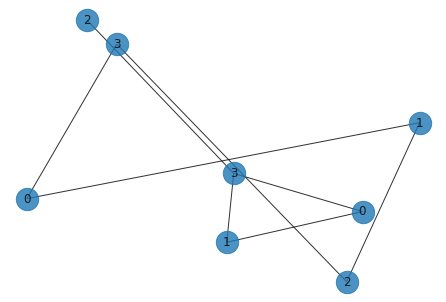

In [20]:
import networkx as nx   # package used for graphing
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit.optimization import QuadraticProgram #CHANGE TO qiskit_optimization
#import basic plot tools
from qiskit.visualization import plot_histogram


graph = nx.Graph()  # create the graph

nodes = [0, 1, 2, 3]    # student nodes
edges = [(0,1,2.0), (0,3,4.0), (1,3,10.0), (2,3,1.0)]    # weighted by number of messages between students
##########################################
A = nx.Graph()
A.add_nodes_from([0, 1, 2, 3])
A.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(A, with_labels=True, alpha=0.8, node_size=500)
##############################################################
# add nodes and edges to graph
graph.add_nodes_from(nodes) 
graph.add_weighted_edges_from(edges)

nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

The next steps of encoding the problem further into a form that the QAOA algorithm can use, namely as QuadraticProgram. Now, translating a weighted graph into a QUBO is very straightforward and can be implemented in the following way, where W is the weight matrix of our graph. 

In [9]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    '''Generates a QuadraticProblem from a graph.
    Args:
        graph: graph of the problem of class nx.Graph
    Returns: 
        quadratic problem of class QuadraticProgram
    '''
    # get weight matrix from the graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0] # number of nodes
    
    # build QUBO matrix Q from weight matrix
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    
    for i in range(size):
        for j in range(size):
            qubo_matrix[i,j] -= weight_matrix[i, j]
            qubo_vector[i] += weight_matrix[i,j]
            
    # define the quadratic program
    quadratic_program = QuadraticProgram('maxcut')
    
    for i in range(size):
        var_name = 'x_{}'.format(i)
        quadratic_program.binary_var(var_name)
        
    quadratic_program.maximize(quadratic=qubo_matrix, linear=qubo_vector, constant=0)
    
    return quadratic_program

For this toy problem we have already seen our parametrized circuit. We see that for any pair of connected edges there is RZZ gate. And for non-connected edges the RZZ gates actually has 0 as a parameter so it doesn’t do anything.

In [10]:
def qaoa_circuit(qubo: QuadraticProgram, gammas, betas, p: int = 1):
    '''
    Given a QUBO instance and the number of layers, construct 
    a corresponding parametrized circuit with p layers.
    Args:
        qubo: The quadratic qubo instance
        p: The number of layers in the QAOA circuit
    Returns: 
        The parametrized QAOA circuit
    '''
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    # Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size, size)
    # Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    # Outer loop to create eahc layer
    for layer in range(p):
        # Apply Rz rotational gates from the cost layer
        for i in range(size):
            w_i = (qubo_linearity[layer] + sum(qubo_matrix[i])) / 2
            qaoa_circuit.rz(phi=gammas[layer]*w_i, qubit=i)
        # Apply the Rzz rotational gates for entangled qubits from cost layer
        for i in range(1,size):
            for j in range(i):
                w_ij = qubo_matrix[i,j]/4
                qaoa_circuit.rzz(theta=gammas[layer]*w_ij, qubit1=i, qubit2=j)
        # Apply single qubit Rx rotations from mixer layer to all qubits
        qaoa_circuit.barrier()
        for i in range(size):
            qaoa_circuit.rx(theta=2*betas[layer], qubit=i)

    # Measure the result in computational basis
    qaoa_circuit.barrier()
    qaoa_circuit.measure(range(size), range(size))

    return qaoa_circuit

Computing energy for a single bitstring is trivial. We can just pluck it in out QUBO problem. For a distribution of measured bitstrings we need to scale the energy with the probability of measuring this bitrsing.

In [11]:
def compute_energy(qubo: QuadraticProgram, x: str):
    """
    Given a bitstring as a solution, returns
    the corresponding energy according to given QUBO.
    Args:
        qubo: The quadratic qubo instance
        x: Solution bitstring      
    Returns:
        e: Energy
    """
    n = len(x)
    v =  np.fromstring(x,'u1') - ord('0')
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()
    e = 0
    for i in range(n):
        for j in range(n):
            e += qubo_matrix[i][j]*v[i]*v[j]
    for i in range(n):
        e += qubo_linearity[i]*v[i]
        
    return e

In [12]:
def compute_expectation(qubo: QuadraticProgram, counts):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                Key as bitstring, val as count
           
        qubo: The quadratic qubo instance
    Returns:
        avg: Expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = compute_energy(qubo, bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count   

In [13]:
def get_expectation(qubo :QuadraticProgram, gammas: ParameterVector, betas: ParameterVector, p: int = 1, shots = 512):
    """
    Runs parametrized circuit
    
    Args:
        qubo: The quadratic qubo instance
        p: Number of repetitions of unitaries
        shots: The number of shots
    """    
    qc = qaoa_circuit(qubo, gammas, betas, p)
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    counts = execute(qc, backend=backend).result().get_counts(qc)
    qc.draw()
    return compute_expectation(qubo, counts)

For a toy problem like ours we can of course compute the energy for all betas and gammas and get this beautiful energy landscape. As we expected we see the periodicity in parameters beta and gamma, which are just scalars in this case. Well, this is explained by the fact that we apply rotational gates. 

In [14]:
Image(url= "images/5nodes.png")

Now maximizing the energy function is done by the SCIPY minimizer which tries to find the global peak in this energy landscape. And the wrapper function that we pass to minimizer is just the energy function multiplied with minus one.

In [19]:
# define our quadratic problem
qubo = quadratic_program_from_graph(graph)

def wrapper(x):
    return -1*get_expectation(qubo, [x[0]], [x[1]], p=1)

# perform the optimization using SCIPY 
#from scipy.optimize import minimize   
#res = minimize(wrapper, x0=[0.0, 1.0], method='COBYLA')
#res     

Running optimization with COBYLA at an initial state 0 1 clearly highlights the right solutions to the problem. Initial state 1 0 in the contrary doesn’t lead to this clear distinction of the two correct solutions from all the other. And as we see SLSQP wasn’t able to find the global maximum as it apparently ends up in local maxima. This is why the classical optimizer is crucial for QAOA.

In [17]:
Image(url="Images/optimizers.jpg")

Finally, there are many possible optimizations to QAOA. And some of them have been only introduced recently. One idea is to choose the starting point in a smart way by precomputing the rotation angles. Another improvement possibility is when computing the energy of samples to only consider a fraction with the highest probabilities during the measurement. Extreme way would be just to pick up the bitstring with the highest probability and calculate energy for it. Another idea is so called warm starting. It essentially means instead of starting with the ground state with is the equal superposition of all states, to pick a state which is closer to the solution. And of course, adjust the mixer Hamiltonian. Now the limiting factor is the device connectivity. When performing the controlled gates between two qubits, which are not directly connected on the actual hardware, the transpiler introduces SWAP-gates which are very costly in terms of runtime. This of course decreases the performance. 
